In [2]:
%pip install fastMONAI
from fastMONAI.vision_all import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/Datasets/datasetT2_200.csv')

Mounted at /content/gdrive


In [4]:
df

,t2_path,subject_id,age_at_scan,age
0,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00051XX02_ses-7702_desc-restore_T2w.nii.gz,7702,40.00,40
1,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00052XX03_ses-8300_desc-restore_T2w.nii.gz,8300,38.71,38
2,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00053XX04_ses-8607_desc-restore_T2w.nii.gz,8607,40.43,40
3,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00054XX05_ses-8800_desc-restore_T2w.nii.gz,8800,42.14,42
4,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00055XX06_ses-9300_desc-restore_T2w.nii.gz,9300,40.43,40
...,...,...,...,...
195,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00342XX13_ses-108300_desc-restore_T2w.nii.gz,108300,43.71,43
196,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00343XX14_ses-108500_desc-restore_T2w.nii.gz,108500,42.00,42
197,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00344XX15_ses-108600_desc-restore_T2w.nii.gz,108600,39.43,39
198,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00345XX16_ses-109000_desc-restore_T2w.nii.gz,109000,39.00,39


In [5]:
df.age.min(), df.age.max(), df.age.mean()

(32, 45, 39.215)

In [6]:
import matplotlib.pyplot as plt

(array([ 0.,  0.,  0.,  4.,  3.,  8.,  7., 11., 16., 18., 27., 40., 31.,
        14., 11.,  8.,  2.]),
 array([29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46.]),
 <BarContainer object of 17 artists>)

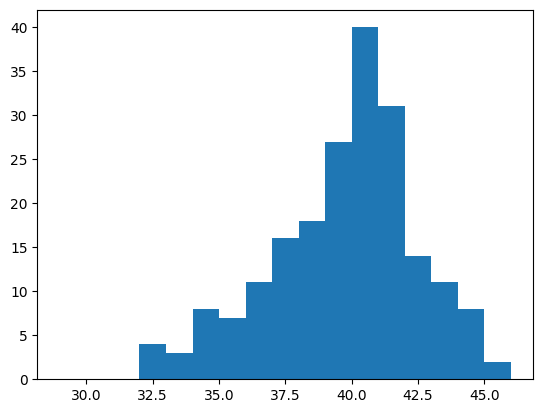

In [7]:
plt.hist(df['age'], bins = 17, range = [29,46])

In [14]:
med_dataset = MedDataset(path= '/content/gdrive/MyDrive/Datasets/T2Restore200', max_workers=12)
data_info_df = med_dataset.summary()

In [15]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,217,290,290,0.5,0.5,0.5,RAS+,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00051XX02_ses-7702_desc-restore_T2w.nii.gz,200


In [16]:
resample, reorder = med_dataset.suggestion()

In [17]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[217.0, 290.0, 290.0]

In [18]:

bs=4
item_tfms = [ZNormalization(), PadOrCrop(img_size), RandomAffine(scales=0, degrees=5, isotropic=False)] 
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), RegressionBlock), 
                      splitter=RandomSplitter(seed=32),
                      get_x=ColReader('t2_path'),
                      get_y=ColReader('age'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [19]:
dls = dblock.dataloaders(df, bs=bs)

In [20]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(160, 40)

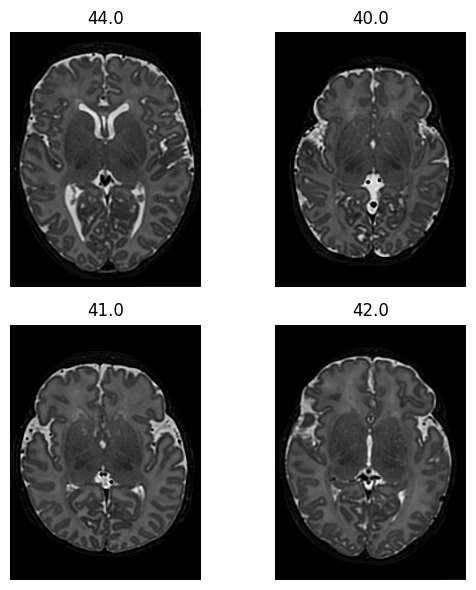

In [21]:
dls.show_batch(anatomical_plane=2)

In [22]:
from monai.networks.nets import Regressor

model = Regressor(in_shape=[1,217, 290, 290], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

In [23]:
loss_func = L1LossFlat()
learn = Learner(dls, model, loss_func=loss_func, metrics=[mae])
learn.summary()

Regressor (Input shape: 4 x 1 x 217 x 290 x 290)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 109 x 145  
Conv3d                                    448        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    448        True      
____________________________________________________________________________
                     4 x 32 x 55 x 73 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    27680      True      
InstanceNorm3d        

In [24]:
lr = 1e-4
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,mae,time
0,11.181874,2.470062,2.470062,48:45
1,6.609880,2.990471,2.990471,48:53
2,4.404261,1.579171,1.579171,48:28
3,2.737571,1.152874,1.152874,48:47


In [25]:
learn.save('model-brainage');
learn.load('model-brainage'); 


In [26]:
interp = Interpretation.from_learner(learn)

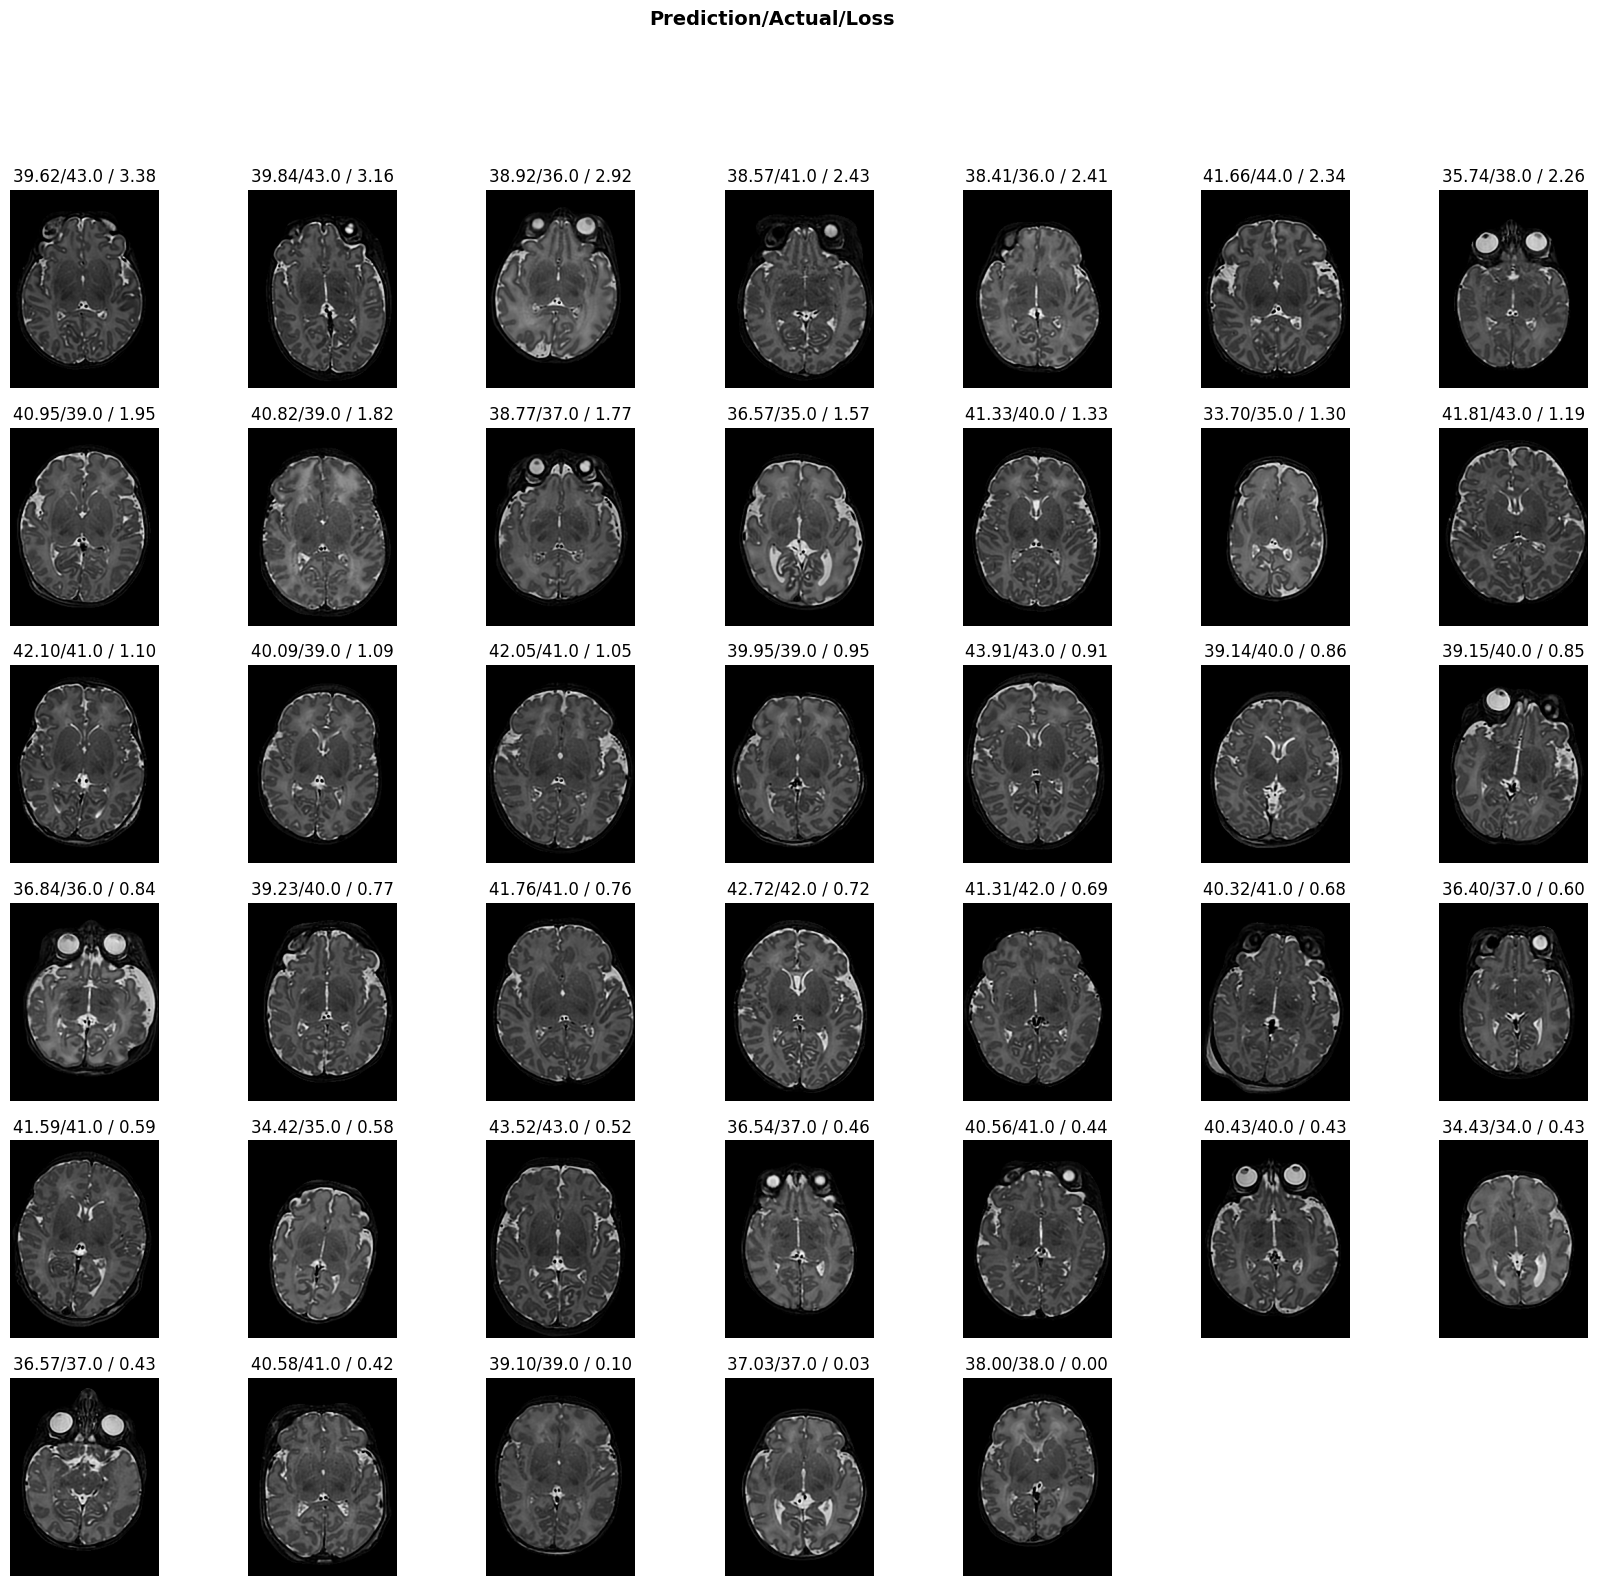

In [27]:
interp.plot_top_losses(k=40, anatomical_plane=2)